In [1]:
import pymongo
client = pymongo.MongoClient()
db = client.test
coll = db.stress
coll.drop()

In [2]:
import time
from functools import wraps


def timed(label):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            n = kwargs.get('n')
            bs = kwargs.get('bs', 1)
            begin = time.time()
            try:
                return func(*args, **kwargs)
            finally:
                elapsed = time.time() - begin
                if n:
                    if bs:
                        n *= bs
                    print('{} {}/s'.format(n / elapsed, label))
                else:
                    print('{}: {}s elapsed'.format(label, elapsed))
        return wrapper
    return decorator

In [3]:
@timed('inserts')
def insert_test(coll, n=1000, bs=1000):
    for ix_n in range(n):
        block = [
            {'ix_n': ix_n, 'ix_b': ix_b}
            for ix_b in range(bs)
        ]
        coll.insert_many(block)
        if ix_n % 40 == 0:
            print()
        print('.', end='', flush=True)
    print()

In [4]:
import random
@timed('queries')
def query_test(coll, max_ix_b, max_ix_n, n=100, bs=10):
    for ix_n in range(n):
        rv_n = random.randint(0, max_ix_n + 1)
        rv_b = random.randint(0, max_ix_b + 1)
        res = coll.find({
            'ix_n': rv_n,
            'ix_b': {'$gt': rv_b}
        })
        list(res)

In [5]:
@timed('updates')
def update_test(coll, max_ix_b, max_ix_n, n=10000):
    for ix_n in range(n):
        rv_n = random.randint(0, max_ix_n + 1)
        rv_b = random.randint(0, max_ix_b + 1)
        coll.update_one(
        {'ix_n': rv_n, 'ix_b': rv_b},
        {'$inc': {'x': 1}})

In [6]:
insert_test(coll, n=500, bs=1000)


........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
....................
64596.601898250876 inserts/s


In [7]:
max_ix_b = 999
max_ix_n = 499
coll.drop_indexes()

In [8]:
db.set_profiling_level(1)

In [9]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.2586154865858985 queries/s


In [10]:
doc = db.system.profile.find_one(sort=[('ts', -1)])

In [11]:
doc

{'op': 'query',
 'ns': 'test.stress',
 'command': {'find': 'stress',
  'filter': {'ix_n': 389, 'ix_b': {'$gt': 967}},
  'lsid': {'id': UUID('6c1472e6-4bb2-48be-85a7-89ca1a06c632')},
  '$readPreference': {'mode': 'secondaryPreferred'},
  '$db': 'test'},
 'keysExamined': 0,
 'docsExamined': 500000,
 'cursorExhausted': True,
 'numYield': 3913,
 'locks': {'Global': {'acquireCount': {'r': 7828}},
  'Database': {'acquireCount': {'r': 3914}},
  'Collection': {'acquireCount': {'r': 3914}}},
 'nreturned': 32,
 'responseLength': 1561,
 'protocol': 'op_query',
 'millis': 174,
 'planSummary': 'COLLSCAN',
 'execStats': {'stage': 'COLLSCAN',
  'filter': {'$and': [{'ix_n': {'$eq': 389}}, {'ix_b': {'$gt': 967}}]},
  'nReturned': 32,
  'executionTimeMillisEstimate': 167,
  'works': 500002,
  'advanced': 32,
  'needTime': 499969,
  'needYield': 0,
  'saveState': 3913,
  'restoreState': 3913,
  'isEOF': 1,
  'invalidates': 0,
  'direction': 'forward',
  'docsExamined': 500000},
 'ts': datetime.datetime(2

In [12]:
for doc in db.system.profile.find({'op': {'$ne': 'command'}}).sort([('ts', -1)]).limit(10):
    print('{millis} {op}'.format(**doc))

174 query
126 getmore
47 query
10 getmore
166 query
22 getmore
155 query
110 getmore
62 query
169 query


In [13]:
db.set_profiling_level(2)

In [14]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.432700596090112 queries/s


In [15]:
for doc in db.system.profile.find({'op': {'$ne': 'command'}}).sort([('ts', -1)]).limit(10):
    print('{millis} {op}'.format(**doc))

183 query
17 getmore
164 query
95 getmore
88 query
20 getmore
160 query
71 getmore
108 query
161 getmore


In [16]:
doc

{'op': 'getmore',
 'ns': 'test.stress',
 'command': {'getMore': 129785085373,
  'collection': 'stress',
  'lsid': {'id': UUID('b93fd65c-5a24-4d74-86ec-c6e4f46d01c1')},
  '$db': 'test',
  '$readPreference': {'mode': 'primary'}},
 'originatingCommand': {'find': 'stress',
  'filter': {'ix_n': 61, 'ix_b': {'$gt': 628}},
  'lsid': {'id': UUID('b93fd65c-5a24-4d74-86ec-c6e4f46d01c1')},
  '$db': 'test',
  '$readPreference': {'mode': 'primaryPreferred'}},
 'cursorid': 129785085373.0,
 'keysExamined': 0,
 'docsExamined': 438270,
 'cursorExhausted': True,
 'numYield': 3426,
 'locks': {'Global': {'acquireCount': {'r': 6854}},
  'Database': {'acquireCount': {'r': 3427}},
  'Collection': {'acquireCount': {'r': 3427}}},
 'nreturned': 270,
 'responseLength': 12663,
 'protocol': 'op_msg',
 'millis': 161,
 'planSummary': 'COLLSCAN',
 'execStats': {'stage': 'COLLSCAN',
  'filter': {'$and': [{'ix_n': {'$eq': 61}}, {'ix_b': {'$gt': 628}}]},
  'nReturned': 371,
  'executionTimeMillisEstimate': 147,
  'works

In [17]:
%matplotlib inline

In [18]:
import pandas as pd

In [19]:
from datetime import datetime
now = datetime.utcnow()

In [20]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.427292899990187 queries/s


In [21]:
df_pre_index = pd.DataFrame(list(db.system.profile.find({'ts': {'$gt': now}})))

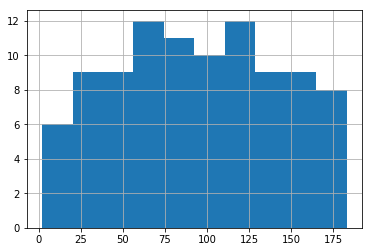

In [22]:
df_pre_index.millis.hist()

In [23]:
coll.create_index([
    ('ix_n', 1)
])

'ix_n_1'

In [24]:
now = datetime.utcnow()

In [25]:
query_test(coll, max_ix_b, max_ix_n, n=50)

263.2536139829381 queries/s


In [26]:
df_post_index = pd.DataFrame(list(db.system.profile.find({'ts': {'$gt': now}})))

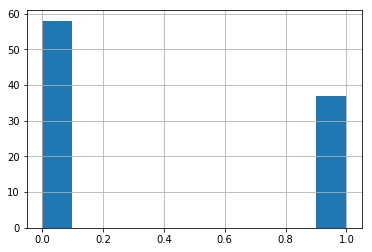

In [27]:
df_post_index.millis.hist()

In [28]:
coll.drop_indexes()

In [29]:
db.set_profiling_level(0)
query_test(coll, max_ix_b, max_ix_n, n=50)

5.455099887292851 queries/s


In [30]:
db.set_profiling_level(1, 200)
query_test(coll, max_ix_b, max_ix_n, n=50)

5.546811284152438 queries/s


In [31]:
db.set_profiling_level(1, 10)
query_test(coll, max_ix_b, max_ix_n, n=50)

5.570421627245266 queries/s


In [32]:
db.set_profiling_level(2)
query_test(coll, max_ix_b, max_ix_n, n=50)

5.575606106475936 queries/s


In [33]:
db.set_profiling_level(1, 1000)
query_test(coll, max_ix_b, max_ix_n, n=50)

5.706104098459812 queries/s
